# TP1 : optimisation sans contrainte

## Exercice 1 : énergie rayonnante d'un corps noir

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import pandas as pd

In [45]:
C0 = 2.997e8  # m/s  vitesse de la lumière dans le vide
h = 6.625e-34  # J.s constante de Planck
k = 1.38e-23  # J/K constante de Boltzmann
n = 1  # indice de réfraction du milieu (ici le vide)


def M(lamb, T):
    """Emittance monocromatique maximale du corps noir"""
    return (2 * np.pi * h * C0**2) / (
        n**2 * lamb**5 * (np.exp(h * C0 / (n * k * T * lamb)) - 1)
    )

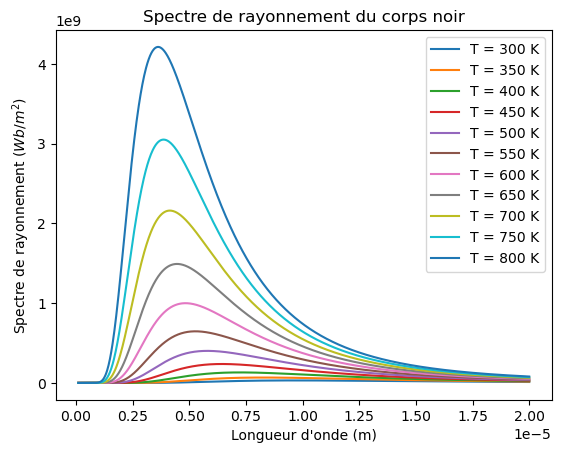

In [46]:
TK = np.arange(300, 850, 50)  # Température de la surface du corps noir en Kelvin
lamb = np.linspace(1e-7, 2e-5, 1000)  # Longueur d'onde en m

for T in TK:
    plt.plot(lamb, M(lamb, T), label="T = %d K" % T)

plt.xlabel("Longueur d'onde (m)")
plt.ylabel(rf"Spectre de rayonnement ($Wb/m^2$)")
plt.legend()
plt.title("Spectre de rayonnement du corps noir")
plt.show()

Si on souhaite utiliser la méthode de la section dorée pour trouver $\lambda^{*}$ il faut s'assurer que la fonction $M(\lambda)$ soit **unimodale** sur l'intervalle $\lambda \in [10^{-7}, 2 \times 10^{-5}]$ sinon la méthode risque de ne pas converger. C'est pour cela qu'on a tracer la courbe de $M(\lambda)$.

http://kengy.barty.free.fr/TP/node9.html


In [47]:
def methode_doree(f, a, b, tol):
    tau = (np.sqrt(5) - 1) / 2
    x1 = a + (1 - tau) * (b - a)
    x2 = a + tau * (b - a)
    f1 = f(x1)
    f2 = f(x2)
    while b - a > tol:
        if f1 < f2:
            b = x2
            x2 = x1
            f2 = f1
            x1 = a + (1 - tau) * (b - a)
            f1 = f(x1)
        else:
            a = x1
            x1 = x2
            f1 = f2
            x2 = a + tau * (b - a)
            f2 = f(x2)
    return (a + b) / 2

3.622193642694696e-06


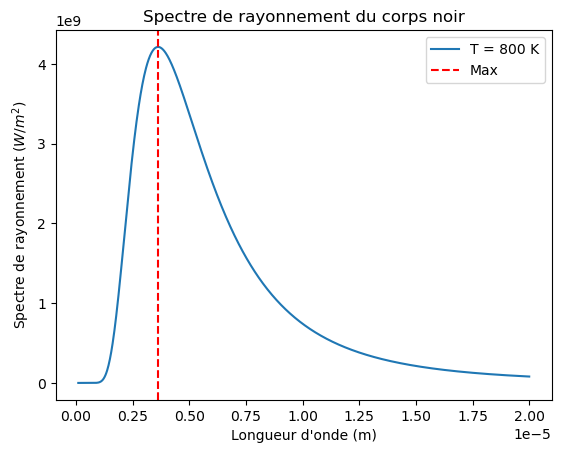

In [48]:
# test
lamb_ = methode_doree(lambda x: -M(x, 800), 1e-7, 2e-5, 1e-10)
print(lamb_)

plt.plot(lamb, M(lamb, 800), label="T = 800 K")
plt.axvline(lamb_, color="r", linestyle="--", label="Max")
plt.xlabel("Longueur d'onde (m)")
plt.ylabel(rf"Spectre de rayonnement ($W/m^2$)")
plt.legend()
plt.title("Spectre de rayonnement du corps noir")
plt.show()

Vérifions les lois de Wien

https://fr.wikipedia.org/wiki/Loi_du_d%C3%A9placement_de_Wien


In [49]:
lamb_max = h * C0 / (4.96511423174 * k * 800)
print("lambda theorique :", lamb_max)
print("lambda numérique :", lamb_)

M_max = M(lamb_max, 800)
print("M(lambda) theorique :", M_max)
print("M(lambda) numérique :", M(lamb_, 800))

lambda theorique : 3.622215690213916e-06
lambda numérique : 3.622193642694696e-06
M(lambda) theorique : 4212954282.4519567
M(lambda) numérique : 4212954282.075356


On voit que les differences sont minimes.


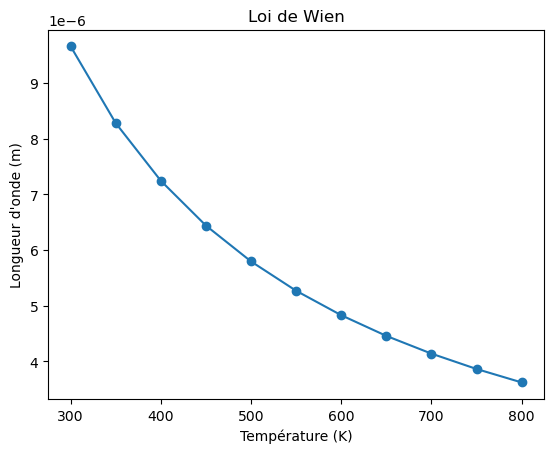

In [50]:
lamb_ = []

for T in TK:
    lamb_.append(methode_doree(lambda x: -M(x, T), 1e-7, 2e-5, 1e-10))

plt.plot(TK, lamb_, "o-")
plt.xlabel("Température (K)")
plt.ylabel("Longueur d'onde (m)")
plt.title("Loi de Wien")
plt.show()

## Exercice 2 : méthodes de type gradient pour des fonctions quadratiques

$$J_n(x) = \frac{1}{2}\langle A_{n}x - b_n, x \rangle_{\mathbb{R}^n}$$


In [51]:
def A(n):
    diagonals = [-2 * np.ones(n - 1), 4 * np.ones(n), -2 * np.ones(n - 1)]
    A = sparse.diags(diagonals, [-1, 0, 1], format="csr")
    return A


def b(n):
    return np.ones(n)


def gradJn(A, b, x):
    return A.dot(x) - b


def Jn(A, b, x):
    res = A @ x - b
    return 0.5 * res @ x

In [52]:
print(A(5).todense())

[[ 4. -2.  0.  0.  0.]
 [-2.  4. -2.  0.  0.]
 [ 0. -2.  4. -2.  0.]
 [ 0.  0. -2.  4. -2.]
 [ 0.  0.  0. -2.  4.]]


In [53]:
# test A symetrique def positive
N = [2, 10, 50, 100]

for n in N:
    A_ = A(n)
    print("A symetrique pour n = %d : " % n, np.all(A_.todense() == A_.T.todense()))
    print(
        "A def positive pour n = %d : " % n,
        np.all(np.linalg.eigvals(A_.todense()) > 0),
    )
    # print("\n")

A symetrique pour n = 2 :  True
A def positive pour n = 2 :  True
A symetrique pour n = 10 :  True
A def positive pour n = 10 :  True
A symetrique pour n = 50 :  True
A def positive pour n = 50 :  True
A symetrique pour n = 100 :  True
A def positive pour n = 100 :  True


In [54]:
A_ = A(2)
b_ = b(2)
x = np.zeros(2)

x_ = sparse.linalg.spsolve(A_, b_)
print("x_ = ", x_)

x_ =  [0.5 0.5]


In [55]:
m = Jn(A_, b_, [0.5, 0.5])
print("min =", m)

min = 0.0


In [56]:
def gradient_pas_fixe(J, gradJ, s, x0, eps=1e-10, max_iter=100_000):
    x = x0
    iterates = [x0]
    k = 0
    while k < max_iter:
        gradx = gradJ(x)
        x = x - s * gradx
        iterates.append(x)
        if np.linalg.norm(gradJ(x)) < eps:
            break
        k += 1
    if k == max_iter:
        print(
            "La methode à pas fixe n'a pas convergé pour eps={} en {} itérations".format(
                eps, max_iter
            )
        )
    return iterates

Il est important de choisir un pas $\alpha$ ni trop grand ni trop petit. En effet si on prend un pas trop grand, on risque de ne pas converger en "rebondissand" d'un bort à l'autre du min. Et si on prend un pas trop petit, on risque de ne pas converger numériquement car on ne se rapproche pas assez vite du min.


In [57]:
def gradient_pas_optimal(J, gradJ, x0, eps=1e-10, max_iter=100_000):
    x = x0
    iterates = [x0]
    k = 0
    while k < max_iter:
        gradx = gradJ(x)
        # methode doree requiert J unimodale
        s = methode_doree(lambda s: J(x - s * gradx), 0, 1, 0.5)
        # s = np.linalg.norm(gradx) / np.dot(A_ @ gradx, gradx)
        x = x - s * gradx
        iterates.append(x)
        if np.linalg.norm(gradJ(x)) < eps:
            break
        # if np.linalg.norm(J(x) - J(x_prev)) < eps:
        #     break
        k += 1
    if k == max_iter:
        print(
            "La methode à pas optimal n'a pas convergé pour eps={} en {} itérations".format(
                eps, max_iter
            )
        )
    return iterates

Questions :

- quelle critère d'arrêt choisir ?  
  Résidu ? Gradient qui ne bouge plus trop ? nombre d'iterations ?

- quelle précision choisir ?


In [58]:
# test
J = lambda x: Jn(A_, b_, x)
gradJ = lambda x: gradJn(A_, b_, x)
# choix un peu a posteriori, on aurait pu choisir (0,0) ou autre
# x0 = np.random.uniform(-10, 10, 2)
x0 = [-10, 10]
# x0 = [0, 0]

lamb_max = np.max(np.linalg.eigvals(A_.todense()))
lamb_min = np.min(np.linalg.eigvals(A_.todense()))
s = 2.0 / (lamb_max + lamb_min)

iterates_fixe = gradient_pas_fixe(J, gradJ, s, x0, 1e-10)
iterates_optimal = gradient_pas_optimal(J, gradJ, x0, 1e-10)
print(
    "Gradient à pas fixe : X_ = {} en {} iterations".format(
        iterates_fixe[-1], len(iterates_fixe)
    )
)
print(
    "Gradient à pas optimal : X_ = {} en {} iterations".format(
        iterates_optimal[-1], len(iterates_optimal)
    )
)

print("Jn(X_fixe)=", Jn(A_, b_, iterates_fixe[-1]))
print("Jn(X_opti)=", Jn(A_, b_, iterates_optimal[-1]))
print("gradJn(X_fixe)=", gradJ(iterates_fixe[-1]))
print("gradJn(X_opti)=", gradJ(iterates_optimal[-1]))

Gradient à pas fixe : X_ = [0.5 0.5] en 41 iterations
Gradient à pas optimal : X_ = [0.5 0.5] en 50 iterations
Jn(X_fixe)= -4.5474735038974216e-13
Jn(X_opti)= -2.87458945519419e-11
gradJn(X_fixe)= [-5.54791768e-11  5.36601874e-11]
gradJn(X_opti)= [-5.74917891e-11 -5.74917891e-11]


In [59]:
eps_values = [1e-6, 1e-8, 1e-10, 1e-12]

for eps in eps_values:
    iterates_fixe = gradient_pas_fixe(J, gradJ, s, x0, eps)
    iterates_optimal = gradient_pas_optimal(J, gradJ, x0, eps)

    print("Tolerance eps =", eps)
    print(
        "Gradient à pas fixe : X_ = {} en {} iterations".format(
            iterates_fixe[-1], len(iterates_fixe)
        )
    )
    print(
        "Gradient à pas optimal : X_ = {} en {} iterations\n".format(
            iterates_optimal[-1], len(iterates_optimal)
        )
    )

Tolerance eps = 1e-06
Gradient à pas fixe : X_ = [0.50000007 0.49999992] en 28 iterations
Gradient à pas optimal : X_ = [0.49999973 0.49999973] en 31 iterations

Tolerance eps = 1e-08
Gradient à pas fixe : X_ = [0.5 0.5] en 34 iterations
Gradient à pas optimal : X_ = [0.5 0.5] en 40 iterations

Tolerance eps = 1e-10
Gradient à pas fixe : X_ = [0.5 0.5] en 41 iterations
Gradient à pas optimal : X_ = [0.5 0.5] en 50 iterations

Tolerance eps = 1e-12
Gradient à pas fixe : X_ = [0.5 0.5] en 48 iterations
Gradient à pas optimal : X_ = [0.5 0.5] en 60 iterations



Contrairement à ce qu'on pourrait pensé la methode à pas optimale n'est pas toujours plus rapide ni plus rapide, cela depend du pas choisie dans la méthode du gradient à pas fixe, des critères d'arrêt, de la précision souhaitée, etc.

En revanche la méthode de gradient à pas optimal est plus robuste car elle ne dépend pas du pas choisi et elle est quand meme en generale plus efficasse.

En particulier on remarque que la méthode de gradient à pas optimal a la facheuse tendance à rester bloquée autour de $(0.25, 0.25)$ (min local? Non car gradient non nul, critère d'arret trop souple?)


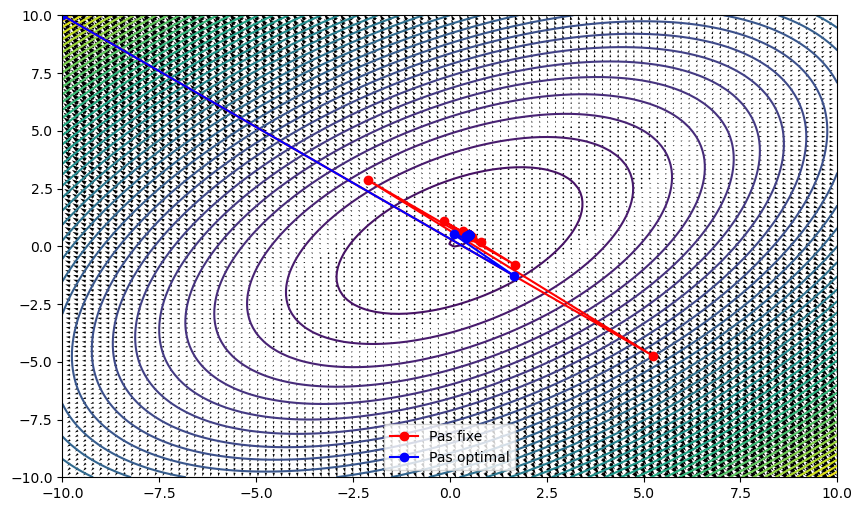

In [60]:
x_values = np.linspace(-10, 10, 100)
y_values = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x_values, y_values)
Z = np.array([Jn(A_, b_, np.array([x, y])) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)  # pour avoir la bonne forme pour plt.contour
U, V = np.array(
    [gradJn(A_, b_, np.array([x, y])) for x, y in zip(np.ravel(X), np.ravel(Y))]
).T

plt.figure(figsize=(10, 6))
plt.contour(X, Y, Z, levels=50)  # affiche les lignes de niveau
plt.quiver(X, Y, U, V)  # affiche les vecteurs gradient
plt.plot(*zip(*iterates_fixe), "ro-", label="Pas fixe")
plt.plot(*zip(*iterates_optimal), "bo-", label="Pas optimal")
plt.legend()
plt.show()

Contrairement à la méthode à pas fixe, ici la méthode à pas optimale ne "rebondit" pas autour du min mais converge directement.


cond(A) =  48.37415007870835
True
cond(A) =  178.06427461085963
True
cond(A) =  388.8121344932579
True
cond(A) =  1053.4789912000572
True
La methode à pas optimal n'a pas convergé pour eps=1e-10 en 100000 itérations
cond(A) =  4133.642926801445
True
     n  Iter fix  Iter opti
0   10       585        758
1   20      2178       2819
2   30      4791       6201
3   50     13110      16954
4  100     52144     100001


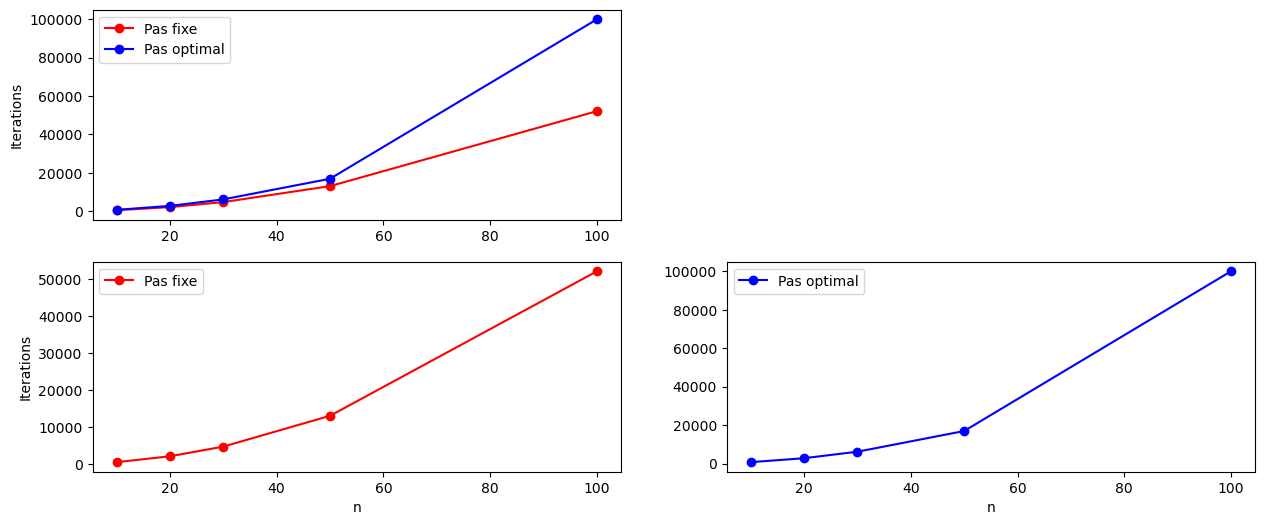

In [61]:
n_values = [10, 20, 30, 50, 100]

iterations_fixe = []
iterations_optimal = []

for n in n_values:
    A_ = A(n).toarray()
    b_ = b(n)
    x0 = np.zeros(n)

    iterates_fixe = gradient_pas_fixe(J, gradJ, s, x0)
    iterates_optimal = gradient_pas_optimal(J, gradJ, x0)

    iterations_fixe.append(len(iterates_fixe))
    iterations_optimal.append(len(iterates_optimal))

    print("cond(A) = ", np.linalg.cond(A_))
    print(np.linalg.norm(iterates_fixe[-1] - iterates_optimal[-1]) < 0.5)

df = pd.DataFrame(
    {
        "n": n_values,
        "Iter fix": iterations_fixe,
        "Iter opti": iterations_optimal,
    }
)

print(df)

fig, ax = plt.subplots(2, 2, figsize=(15, 6))

ax[0, 0].plot(n_values, iterations_fixe, "ro-", label="Pas fixe")
ax[0, 0].plot(n_values, iterations_optimal, "bo-", label="Pas optimal")
ax[0, 0].set_ylabel("Iterations")
ax[0, 0].legend()

ax[0, 1].axis("off")

ax[1, 0].plot(n_values, iterations_fixe, "ro-", label="Pas fixe")
ax[1, 0].set_xlabel("n")
ax[1, 0].set_ylabel("Iterations")
ax[1, 0].legend()

ax[1, 1].plot(n_values, iterations_optimal, "bo-", label="Pas optimal")
ax[1, 1].set_xlabel("n")
ax[1, 1].legend()

plt.show()

C'est difficile à interpreter, celon le pas choisi, les critères d'arrêt, la précision souhaitée, etc. la méthode de gradient à pas fixe peut être plus rapide que la méthode de gradient à pas optimal.

De plus le conditionnement de la matrices $A$ est tres mauvais, ce qui explique les probleme de convergence.

On note neanmoins que la croissance des iterations respective semble être la même, exponentielle pour les deux méthodes.

Au moins on à vérifié qu'on converge vers le même minimum avec les 2 méthodes.


## Exercice 3 : Fonction de Rosenbrock

$$f(x, y) = (x - 1)^2 + 10(x^2 - y)^2$$

$$\nabla f(x, y) = \begin{pmatrix} 2(x-1) + 40x(x^2 - y) \\ -20(x^2 - y) \end{pmatrix}$$


Cherchons les points critiques de f :

$$
\begin{align*}
&\nabla f(x, y) = 0 \Leftrightarrow \begin{cases}
2(x-1) + 40x(x^2 - y) = 0  \\
-20(x^2 - y) = 0
\end{cases} &\\
&\Rightarrow \begin{cases}
40x^3 - 40xy + 2x - 2 = 0 \\
-x^2 + y = 0
\end{cases} &\\
&\Rightarrow \begin{cases}
40x^3 - 40xy + 2x - 2 = 0 \\
y = x^2
\end{cases} &\\
&\Rightarrow \begin{cases}
40x^3 - 40x^3 + 2x - 2 = 0 \\
y = x^2
\end{cases} &\\
&\Rightarrow \begin{cases}
2x - 2 = 0 \\
y = x^2
\end{cases} &\\
&\Rightarrow \begin{cases}
x = 1 \\
y = 1
\end{cases} &\\
\end{align*}
$$


Le seul point critique de la fonction $f(x, y)$ est $(1, 1)$.

On veut montrer que c'est un minimum global.

Pour cela, on va calculer la matrice hessienne de $f(x, y)$ et vérifier qu'elle est définie positive en $(1, 1)$.

$$
\begin{align*}
&H_f = \begin{pmatrix}
\frac{\partial^2 f}{\partial x^2} & \frac{\partial^2 f}{\partial x \partial y} \\
\frac{\partial^2 f}{\partial y \partial x} & \frac{\partial^2 f}{\partial y^2}
\end{pmatrix}\\
&H_f = \begin{pmatrix}
\frac{\partial}{\partial x}(2 + 120x^2 - 40y) & \frac{\partial}{\partial x}(-40x) \\
\frac{\partial}{\partial y}(-40x) & \frac{\partial}{\partial y}20
\end{pmatrix}\\
&\frac{\partial^2 f}{\partial x^2} = 240x, \quad \frac{\partial^2 f}{\partial y^2} = 0, \quad \frac{\partial^2 f}{\partial x \partial y} = -40, \quad \frac{\partial^2 f}{\partial y \partial x} = -40\\
&H_f = \begin{pmatrix}
240x & -40 \\
-40 & 0
\end{pmatrix}\\
&det(H_f) = 240x \cdot 0 - (-40) \cdot (-40) = 1600 > 0 \\
\end{align*}
$$

Donc, $(1,1)$ est un mininum de $f$, comme c'est le seul il est unique.


$$
\begin{align*}
\nabla^2 f(x, y) = \begin{pmatrix} 240x & -40 \\ -40 & 0 \end{pmatrix} \\
\nabla^2 f(1, 1) = \begin{pmatrix} 240 & -40 \\ -40 & 0 \end{pmatrix} \\

\end{align*}
$$


In [62]:
nabla2 = np.array([[240, -40], [-40, 0]])
cond = np.linalg.cond(nabla2)
print("conditionnement =", cond)

conditionnement = 37.97366596101027


Soit $A \in \mathcal{GL}_n(\mathbb{C})$
$$cond_{*}(A) = ||A||_* \cdot ||A||_{*}^{-1}$$

Le conditionnement informe sur la stabilité du syteme. Plus il est grand, plus le système est instable.

Remarque : $$cond(A) \geq 1$$

Donc idealement on veut on un conditionnement le plus proche possible de 1.

Remarque : le conditionnement depend de la norme choisie.


In [63]:
def rosenbrock(x, y):
    return (x - 1) ** 2 + 10 * (x**2 - y) ** 2

In [64]:
def gradient_pas_optimal(J, gradJ, x0, eps=1e-5, max_iter=100_000):
    x = x0
    iterates = [x0]
    k = 0
    while k < max_iter:
        x_prev = x
        gradx = gradJ(x)
        s = methode_doree(lambda s: J(x - s * gradx), 0, 1, 1e-4)
        x = x - s * gradx
        iterates.append(x)
        if np.linalg.norm(J(x) - J(x_prev)) < eps:
            break
        k += 1
    if k == max_iter:
        print(
            "La methode à pas optimal n'a pas convergé pour eps={} en {} itérations".format(
                eps, max_iter
            )
        )
    return iterates

Gradient à pas fixe : X_ = [1. 1.] en 55271 iterations
Gradient à pas optimal : X_ = [0.97690326 0.95405281] en 249 iterations


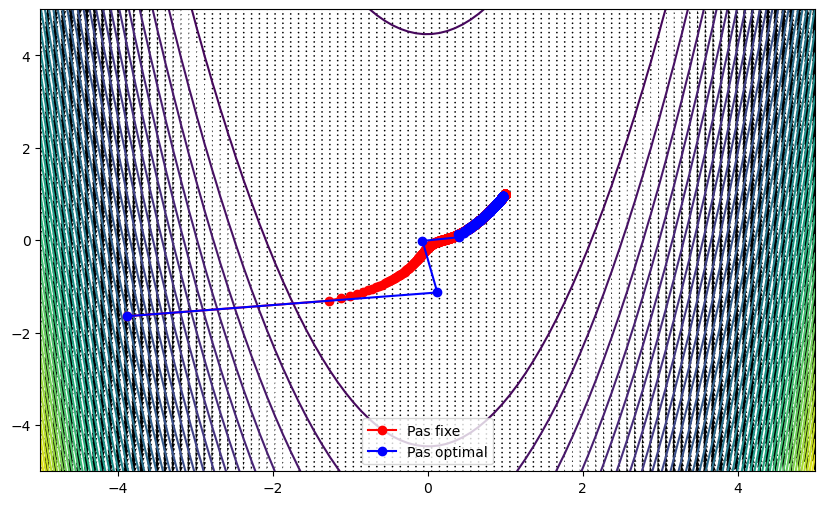

In [65]:
J = lambda x: rosenbrock(x[0], x[1])
gradJ = lambda x: np.array(
    [2 * (x[0] - 1) + 40 * x[0] * (x[0] ** 2 - x[1]), -20 * (x[0] ** 2 - x[1])]
)

x0 = np.random.uniform(-5, 5, 2)

iterates_fixe = gradient_pas_fixe(J, gradJ, 1e-3, x0)
iterates_optimal = gradient_pas_optimal(J, gradJ, x0)
print(
    "Gradient à pas fixe : X_ = {} en {} iterations".format(
        iterates_fixe[-1], len(iterates_fixe)
    )
)
print(
    "Gradient à pas optimal : X_ = {} en {} iterations".format(
        iterates_optimal[-1], len(iterates_optimal)
    )
)

x_values = np.linspace(-5, 5, 100)
y_values = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x_values, y_values)
Z = rosenbrock(X, Y)
U, V = np.gradient(Z)

plt.figure(figsize=(10, 6))
plt.contour(X, Y, Z, levels=50)
plt.quiver(X, Y, U, V)
plt.plot(*zip(*iterates_fixe), "ro-", label="Pas fixe")
plt.plot(*zip(*iterates_optimal), "bo-", label="Pas optimal")
plt.legend()
plt.show()

Les méthodes de gradient dependent du condionnement de la hessienne, si on fait tourner le code si dessus plusieurs fois, on se rend compte que la methode ne converge pas toujours tres bien, en particuliier la méthode de gradient à pas optimale fait parfois de grand "saut".

Peut-être qu'on pourrait utiliser une méthode de gradient conjugué avec un preconditionneur pour améliorer la convergence.

Ici la méthode de gradient à pas optimale converge extremement plus vite que la méthode de gradient à pas fixe.

Celon le critere d'arret choisi, la précision de la methode de gradient, la précision de la methode dorée, ca change beaucoup la convergence de la methode à pas optimal.


### Conclusion

Connaitre les algorithmes des methodes de gradient ne fait pas tout, pour pouvoir les utiliser correctement il faut avoir une bonne connaissance du probleme, de la nature de la fonction minimiser, des conditions de convergence, des critères d'arrêt, des précisions souhaitées, du condionnement de la matrice, etc.
